In [17]:
import os
import sys

import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pandas as pd
import matplotlib.pyplot as plt

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

np.random.seed(42)
C0 = '#005AFF'
C1 = '#FF4B00'

if "../scripts" not in sys.path:
    sys.path.append("../scripts")
    
plt.rcParams["font.size"] = 18
%matplotlib inline
%config InlineBackend.figure_formats = ['png']
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare the data by solve Simple Limit Cycle
$$ \dot{y_0} = \alpha y_0 - \omega y_1 - y_0 (y_0^2 + y_1^2) $$
$$ \dot{y_1} = \omega y_b + \alpha y_1 - y_1 (y_0^2 + y_1^2) $$

$\omega$, $\alpha$ are parameter.


In [18]:
from scipy.integrate import solve_ivp
dim_x = 2
alpha = 1.
omega = 2.0
mu = 1e0
epoch = 500
N = 100
T = 2 * np.pi / omega * .5
delta_t = T / N
data = np.empty((epoch, N, dim_x))
times = np.empty((epoch, N, 1))

def exponential_decay(t, y):
    y0 = alpha * y[0] - omega * y[1] - y[0] * (y[0] ** 2 + y[1] ** 2)
    y1 = omega * y[0] + alpha * y[1] - y[1] * (y[0] ** 2 + y[1] ** 2)
    return np.asarray([y0, y1])

for i in range(epoch):
    r = np.random.randn() * 2.0 + np.sqrt(alpha)
    th = np.random.uniform(-np.pi, np.pi)
    x0 = np.array([r * np.cos(th), r * np.sin(th)])  

    t = np.arange(N) * delta_t
    sol = solve_ivp(exponential_decay, [0, T], y0=x0, t_eval=t)
    data[i] = sol.y.T
    times[i] = sol.t.reshape(-1, 1)

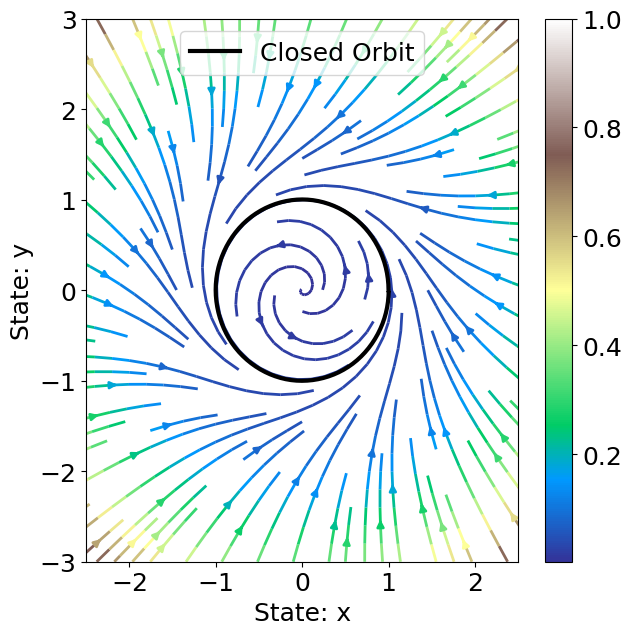

In [19]:
w = 3

# Varying color along a streamline
s = np.array([np.sqrt(alpha), 0])
period_time = 2 * np.pi / omega
t_eval = np.arange(0, period_time / delta_t) * delta_t
sol = solve_ivp(exponential_decay, [0, period_time], y0=s, t_eval=t_eval)
orbit = sol.y

grids = np.mgrid[-w:w:50j, -w:w:50j]
Flow = exponential_decay(t=0, y=grids)
norm = np.linalg.norm(Flow, axis=0)
norm /= norm.max()

fig = plt.figure(figsize=(3.35 * 2, 3.35 * 2))
strm = plt.streamplot(grids[0].T, grids[1].T, Flow[0].T, Flow[1].T, color=norm.T, linewidth=2, density=1, cmap="terrain") 
plt.plot(orbit[0], orbit[1], linewidth=3, c="black", label="Closed Orbit")
plt.colorbar(strm.lines)
plt.legend()
plt.xlim(-2.5, 2.5)
plt.xlabel("State: x")
plt.ylabel("State: y")
# plt.title('limitcycle space')
plt.tight_layout()
plt.show()

# Learning

In [20]:
trajectory = torch.tensor(data, dtype=torch.float32, device="cuda")
trajectory = trajectory.cuda()
dt = np.diff(times, axis=1).mean()

print("traj.shape", trajectory.shape, "dt", dt)

traj.shape torch.Size([500, 100, 2]) dt 0.015707963267948963


In [21]:
from phase_amplitude_reduction import PADynTrainer

dim_obs = trajectory.shape[-1]
recon_loss_coef = torch.ones(dim_obs, dtype=trajectory.dtype, device=trajectory.device) * 1.0
beta = alpha * 2

trainer = PADynTrainer(
    dim_latent=2,
    dim_obs=dim_obs,
    hidden_layer_size=[512, 512],
    delta_t=dt,
    device="cuda",
    num_iters=5000,
    learning_rate=1e-3,
    discount_gamma=0.99,  # 0.99 ** 50 ~ 0.6
    latent_noise=1e-5,
    natural_freq=omega / (2 * np.pi),
    amplitude_range=[beta, beta],
    recon_loss_coef=recon_loss_coef
)

In [ ]:
trainer.learn(trajectory[:trajectory.shape[0]  // 2, :trajectory.shape[1]])
trainer.save("../data/simple_limit_cycle_model.pt")
model = trainer.load("../data/simple_limit_cycle_model.pt")
model.to("cuda")
trainer =  model

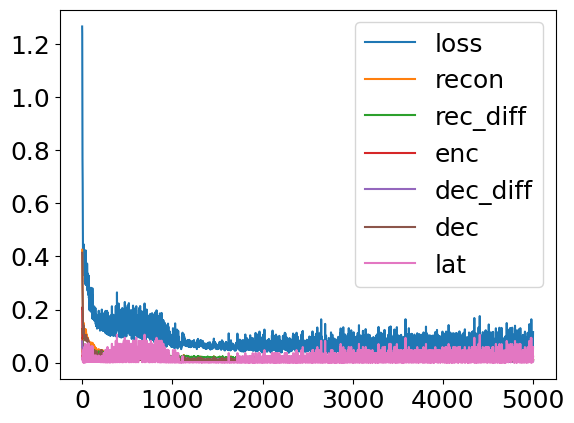

In [23]:
loss = np.array([x.detach().cpu() for x in trainer.record["loss"]])
loss_recon = np.array([x.detach().cpu() for x in trainer.record["loss_recon"]])
loss_rec_diff = np.array([x.detach().cpu() for x in trainer.record["loss_rec_diff"]])
loss_enc = np.array([x.detach().cpu() for x in trainer.record["loss_enc"]])
loss_dec_diff = np.array([x.detach().cpu() for x in trainer.record["loss_dec_diff"]])
loss_dec = np.array([x.detach().cpu() for x in trainer.record["loss_dec"]])
loss_lat = np.array([x.detach().cpu() for x in trainer.record["loss_lat"]])

plt.plot(loss, label="loss")
plt.plot(loss_recon, label="recon")
plt.plot(loss_rec_diff, label="rec_diff")
plt.plot(loss_enc, label="enc")
plt.plot(loss_dec_diff, label="dec_diff")
plt.plot(loss_dec, label="dec")
plt.plot(loss_lat, label="lat")
plt.legend()

In [24]:
T = data.shape[1]
traj = torch.tensor(data, dtype=torch.float32, device="cuda")
obs_pred, latent = trainer.rollout(traj[:, 0:1], T, predict=True)
latent = latent.detach().cpu()
obs_pred = obs_pred.detach().cpu().numpy()

with torch.no_grad():
    latent_enc = trainer.enc(traj)
    obs_rec= trainer.dec(latent_enc)
    obs_rec = obs_rec.detach().cpu().numpy()
    latent_enc = latent_enc.detach().cpu().numpy()

torch.Size([900, 2])
0 37.865902


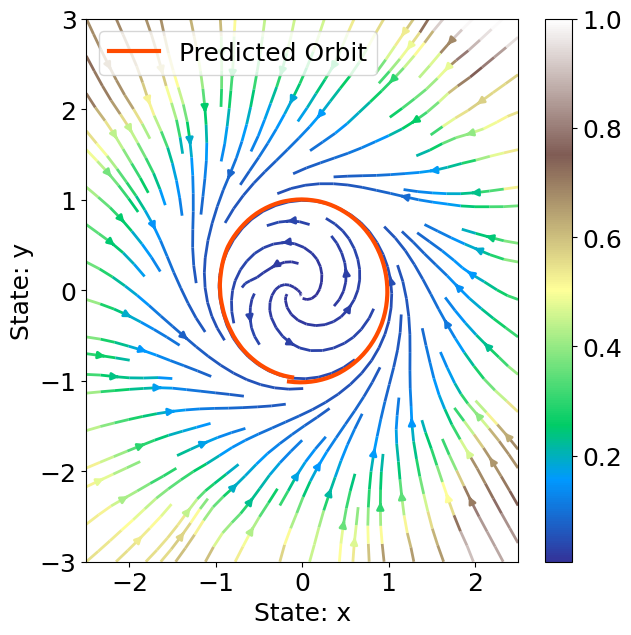

In [25]:
w = 2.5
w2 = 3.0
grids = np.mgrid[-w:w:30j, -w2:w2:30j]
_, height, width = grids.shape

grids_tf = torch.empty((1, grids.size // 2, 2), device="cuda", dtype=torch.float32)
for i in range(height):
    for j in range(width):
        grids_tf[0, i * width + j, 0] = grids[0, i, j]
        grids_tf[0, i * width + j, 1] = grids[1, i, j]


lat = trainer.enc(grids_tf[0])
print(lat.shape)
x_hat = trainer.dec(lat)
h_grad = torch.empty(
    (x_hat.size(0), x_hat.size(1), lat.size(-1)), 
    device=grids_tf.device, dtype=grids_tf.dtype
)
lat.retain_grad()
for i in range(2):
    lat.grad = None
    x_hat[:, i].sum().backward(retain_graph=True)
    h_grad[:, i] = lat.grad
    
field = torch.empty_like(lat)
field[:, 0] = trainer.dyn._time_constants[0]
field[:, 1:] = trainer.dyn._time_constants[1:] * lat[:, 1:]
xxx = torch.einsum("ijk, ik->ij", h_grad, field)
xxx = xxx.reshape(1, -1, 2)

Flow_tf = torch.empty(grids.shape)
for i in range(height):
    for j in range(width):
        Flow_tf[0, i, j] = xxx[0, i * width + j, 0]
        Flow_tf[1, i, j] = xxx[0, i * width + j, 1]
        
Flow = Flow_tf.detach().cpu().numpy()

norm = np.linalg.norm(Flow, axis=0)
norm /= norm.max()
print(np.isnan(Flow).sum(), Flow.max())

fig = plt.figure(figsize=(3.35 * 2, 3.35 * 2))
strm = plt.streamplot(grids[0].T, grids[1].T, Flow[0].T, Flow[1].T, color=norm.T, linewidth=2, density=1, cmap="terrain") 
term = int((1 / (omega / 2 / np.pi)) / dt + 2)
traj = torch.tensor(data[0:1, -1:], dtype=torch.float32, device="cuda")
pred_orbit, latent = trainer.rollout(traj[0:1, 0:1], term, predict=True)
pred_orbit = pred_orbit.detach().cpu().numpy()

plt.plot(pred_orbit[0, :, 0], pred_orbit[0, :, 1], linewidth=3,  c="#FF4B00", label="Predicted Orbit")
plt.colorbar(strm.lines)
plt.legend()
plt.xlabel("State: x")
plt.ylabel("State: y")
# plt.title('limitcycle space')
plt.tight_layout()
plt.show()

In [26]:
print("data shape:", obs_pred.shape, data.shape)
print("train size:{}, test size:{}".format(data.shape[0] // 2, data.shape[0] // 2))
num_data = data.shape[0]
norm = np.square(obs_pred[num_data // 2:] - data[num_data // 2:]).sum(axis=2)
RMSE = np.sqrt(norm.mean(axis=1)).mean(axis=0)
print(f"test RMSE:{RMSE:.5f}")

data shape: (500, 100, 2) (500, 100, 2)
train size:250, test size:250
test RMSE:0.04694
